## Adding identical features

In [17]:
import numpy as np
from scipy import stats
from scipy.stats import bernoulli
import pandas as pd
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from doubleml import DoubleMLData
from doubleml import DoubleMLPLR

In [18]:
seed = 123
np.random.seed(seed)

In [19]:
########################
#### Generate data #####
########################
def gen_features(n_samples,n_features, c,treatment_prob, distribution, noise,seed):
    if distribution == 'gaussian':
        X = np.random.randn(n_samples, int(n_features/2))
        #create identical features
        X = np.repeat(X,2, axis = 1)
        D =  bernoulli.rvs(p = treatment_prob,size=n_samples) # treatment var
        dx = np.column_stack((D,X))
        trt_effect = c
        weights = np.append(trt_effect, stats.norm.rvs(0, 1, size = n_features))#add the constant then random variabel
#        weights = np.random.rand(n_features)
        Y = np.dot(dx,weights.T)
        if noise >0.0:
            Y += stats.norm.rvs(loc = 0, scale=noise,size=Y.shape)     
    
    elif distribution == 'bernoulli':
        # generate X features
        p_vec = np.random.uniform(size = int(n_features/2))
        X = stats.bernoulli.rvs(p = p_vec, size = [n_samples,int(n_features/2)])
        X = np.repeat(X,2, axis = 1)
        
        #add the treatment var into X data        
        D = bernoulli.rvs(p = treatment_prob,size=n_samples) # treatment var
        dx = np.column_stack((D,X))
        
        #generate weights
        trt_effect = c
        weights = np.append(trt_effect, stats.norm.rvs(0, 1, size = n_features))#add the constant then random variabel
        Y = np.dot(dx,weights.T)
        #implement noise for bernoulli with noise = p(flip bit)
        if noise >0.0:
            #Y_multiplier = [-1 if random.random() < noise else 1 for i in Y]
            #Y = Y * Y_multiplier
            Y += stats.norm.rvs(loc = 0, scale=noise,size=Y.shape)  
            
    else:
        print("Not a valid distribution")
    
    return X,dx,weights, Y, D

#create empty df to hold 
df = pd.DataFrame(columns=['Run', 'OLS','OLS_LB','OLS_UB','std_err','DML','DML_err', 'DML_LB','DML_UB','DML_t_stat','DML_reg','DML_reg_err', 'DML_reg_LB','DML_reg_UB','DML_reg_t_stat','num_samples','distribution','num_features','noise'])

#define simulation parameters
c = 0.5 #float
num_runs = [1,2,3] #array of integers
data_distribution = ["bernoulli","gaussian"] #gaussian/bernoulli
num_samples = [1000000] #array of integers
num_feats = [30] #array of integers
noises = [0] #array of floats. normally distributed noise centered around 0. This value changes the std
trt_prob = [0.9]

############################
#### Execute simulation ####
############################
for run in num_runs:
    for feature_num in num_feats:
        for samples in num_samples:
            for dist in data_distribution:
                for noise in noises:
                #generate data
                    X,dx, weights,Y,D = gen_features(n_samples=samples,n_features=feature_num,c=c,treatment_prob=trt_prob,distribution=dist,noise=noise, seed=seed)
                    ######################################################################    
                    # OLS --------------------------------------------------     
                    ######################################################################
                    OLS = sm.OLS(Y,dx)
                    results = OLS.fit()        
                    
                    ####
                    ##Add confidence interval for OLS
                    ols_LB = results.conf_int(alpha=0.05, cols=None)[0][0]
                    ols_UB = results.conf_int(alpha=0.05, cols=None)[0][1]            
                    std_err = results.bse[0]
                    
                    
                    ######################################################################
                    # DML package                      -----------------------------------     
                    ######################################################################
                    # DML ml_m_rf as classifier        -----------------------------------     
                    ######################################################################
                    dml_data = DoubleMLData.from_arrays(X, Y, D)
                    
                    ml_g_rf = RandomForestRegressor(n_estimators=100,max_depth=10, n_jobs = -1)
                    ml_m_rf = RandomForestClassifier(n_estimators=100,max_depth=10, n_jobs = -1)
                    
                    dml_plr_tree = DoubleMLPLR(dml_data, ml_g = ml_g_rf, ml_m = ml_m_rf)
                    #estimation
                    dml_plr_tree.fit()
                
                    ######################################################################
                    # DML package                      -----------------------------------     
                    ######################################################################
                    # DML ml_m_rf as regressor        -----------------------------------     
                    ######################################################################
                    
                    ml_m_rfreg = RandomForestRegressor(n_estimators=100,max_depth=10, n_jobs = -1)
                    
                    dml_plr_tree_reg = DoubleMLPLR(dml_data, ml_g = ml_g_rf, ml_m = ml_m_rfreg)
                    #estimation
                    dml_plr_tree_reg.fit()
                    
                    row = [run,results.params[0],ols_LB,ols_UB,std_err, dml_plr_tree.coef,dml_plr_tree.se, dml_plr_tree.confint().iloc[0][0],dml_plr_tree.confint().iloc[0][1],dml_plr_tree.t_stat,dml_plr_tree_reg.coef,dml_plr_tree_reg.se, dml_plr_tree_reg.confint().iloc[0][0],dml_plr_tree_reg.confint().iloc[0][1],dml_plr_tree_reg.t_stat,samples,dist, feature_num, noise]
                    df.loc[len(df)] = row

KeyboardInterrupt: 

In [20]:
#clean values in dataframe
df[['DML','DML_err','DML_t_stat','DML_reg','DML_reg_err','DML_reg_t_stat']] = df[['DML','DML_err','DML_t_stat','DML_reg','DML_reg_err','DML_reg_t_stat']].apply(lambda x: x.str[0])

#Generate df with average values
mean_df = df.groupby(['distribution','num_samples','noise']).mean()

In [21]:
df

,Run,OLS,OLS_LB,OLS_UB,std_err,DML,DML_err,DML_LB,DML_UB,DML_t_stat,DML_reg,DML_reg_err,DML_reg_LB,DML_reg_UB,DML_reg_t_stat,num_samples,distribution,num_features,noise
0,1,0.5,0.499993,0.500007,3.357201e-06,0.499907,0.001018,0.497912,0.501903,491.046810,0.499834,0.001018,0.497838,0.501829,490.923677,1000000,bernoulli,30,0
1,1,0.5,0.500000,0.500000,6.733688e-18,0.498341,0.008781,0.481132,0.515551,56.755030,0.501506,0.008790,0.484278,0.518735,57.053137,1000000,gaussian,30,0
2,2,0.5,0.499998,0.500002,1.009086e-06,0.499962,0.000737,0.498518,0.501406,678.655929,0.499848,0.000737,0.498405,0.501292,678.599007,1000000,bernoulli,30,0
3,2,0.5,0.500000,0.500000,6.911595e-18,0.499853,0.007567,0.485022,0.514683,66.059678,0.499125,0.007570,0.484288,0.513962,65.933546,1000000,gaussian,30,0
4,3,0.5,0.500000,0.500000,9.762238e-08,0.499824,0.000539,0.498767,0.500881,926.960780,0.499000,0.000541,0.497939,0.500060,921.897172,1000000,bernoulli,30,0


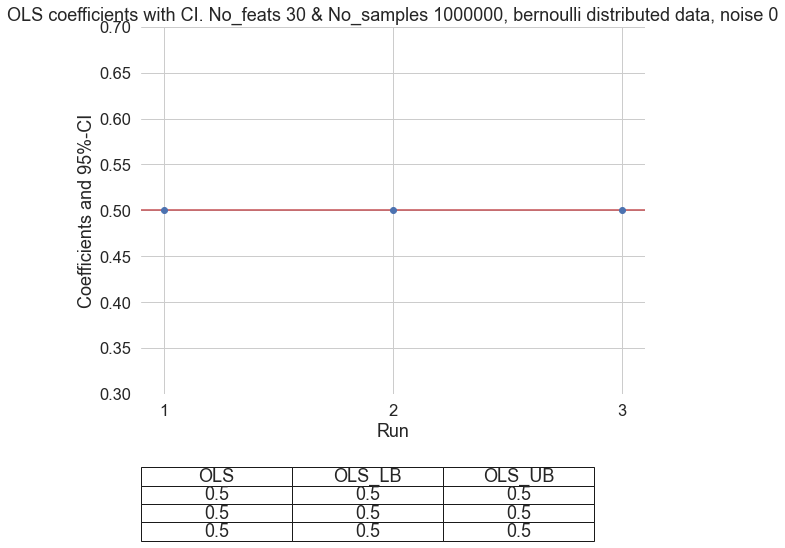

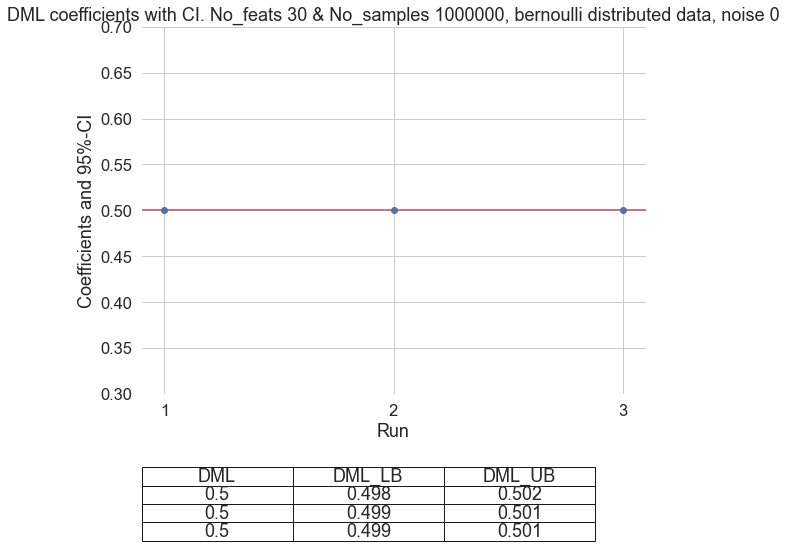

ValueError: 'x' and 'y' must have the same size

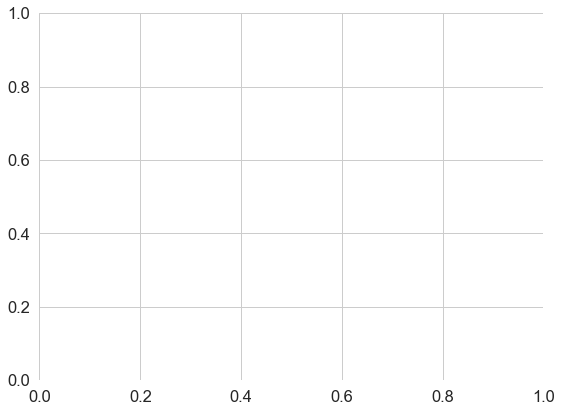

In [22]:
#set visualisation settings
sns.set()
colors = sns.color_palette()
plt.rcParams['figure.figsize'] = 10., 7.5
sns.set(font_scale=1.5)
sns.set_style('whitegrid', {'axes.spines.top': False,
                            'axes.spines.bottom': False,
                            'axes.spines.left': False,
                            'axes.spines.right': False})

####################
# Visualisation    #
####################

########################################
#VISUALISATION FUNCTIONS               #
########################################
#function to extract data to be visualised in a table the CI graph function
def extract_table_text(table):
    cell_text=[]
    for row in range(len(table)):
        cell_text.append(table.iloc[row].round(3))
    return cell_text    

#function to show OLS coefficients and their confidence intervals
def generate_CI_graph(df,feats,samples,num_runs,distribution,noise, method):
    meth = method
    meth_ub = method+"_UB"
    meth_lb = method + "_LB"
    #query dataset
    temp_df2 = df.query('num_features== {0} & num_samples=={1} & distribution=="{2}" & noise=={3}'.format(feats,samples,distribution, noise))
    temp_df = np.full((2, temp_df2.shape[0]), np.nan)
    temp_df[0, :] = temp_df2[method] - temp_df2[meth_lb]
    temp_df[1, :] = temp_df2[meth_ub] - temp_df2[meth]
    # Adjust layout to make room for the table:
    plt.subplots_adjust(left=0.2, bottom=0.2)
    
    plt.errorbar(num_runs, temp_df2[meth], fmt='o', yerr=temp_df)
    
    #plot tables
    data_table = temp_df2.filter(items=[method, meth_lb,meth_ub])
    cell_text = extract_table_text(data_table)
    plt.table(cellText=cell_text, colLabels=data_table.columns, cellLoc = 'center', 
              rowLoc = 'center',loc='bottom',bbox=[0.0, -0.4, 0.9, 0.2])
    #plot real inference value as red horizontal line
    plt.axhline(y=c, color='r', linestyle='-')
    plt.title('{} coefficients with CI. No_feats {} & No_samples {}, {} distributed data, noise {}'.format(method,feats,samples,dist,noise))
    plt.xlabel('Run')
    plt.ylim(0.3,0.7) #standardise visualisation
    plt.xticks(np.arange(1, max(num_runs)+1, 1))  # Set label locations for three runs. 
    _ =  plt.ylabel('Coefficients and 95%-CI')   
    plt.show()
    
####################
#generate plots    #
####################
for feature_num in num_feats:
        for samples in num_samples:
            for dist in ['bernoulli','gaussian']:
                for noise in noises:
                    for meth in ["OLS","DML"]:
                        generate_CI_graph(df,feature_num,samples,num_runs,dist,noise,meth)